# Bridge Crossing

The bridge crossing model is another example of a Markov Decision Process. What you are concerned with in this scenario is the route. We are not saying it is the <em>optimal</em> one, but slowly, it will teach our intelligent agent about policy decisions.

Recall that a policy in a Markov Decision Process (MDP) is a rule that tells the agent what action to take in each state. A policy can be deterministic or probabilistic.

For Reference, this is the <em>approximation</em> of the model we will develop. We will keep its abstraction intact.
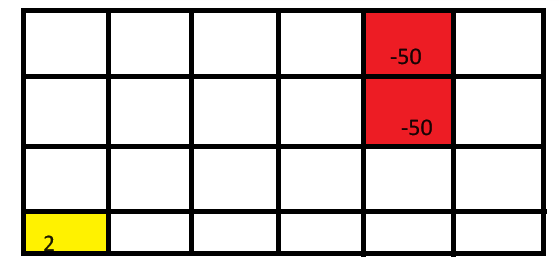

In this model (<em>which is a matrix representing the world</em>), the 2 cost is the reward for hitting the bottom node. If we hit the red nodes, its -50 in reward.
We start from the node (1,1) which is basically the top left node. For this instance of the problem, the goal node is (1,6) which is the top right node.

<ul>
    <li>The agent has a choice(validations are there ofcourse) to move in four directions, North, East, West, South.</li>
    <li>The probability of each direction is 0.25 .</li>
    <li>The cost of each node is constant = -0.1 .</li>
    <li>The agent is expected to take a random path.</li>
</ul>

<strong>Note:</strong><em>There is a possible slip factor having probability 0.8 in this case for the squares immediately next to the red squares. You are supposed to terminate the agent's search on hitting that probability. Also, the $\gamma$
factor for this problem is 1.</em>

# Node Class
The node class represents the step of the agent.

In [21]:
class BridgeNode:
    def __init__(self, loc, slip_probability=0, cost=-0.1):
        """
            Represents the step of the agent.
            
            Args:
                loc (Tuple) : (x,y) representing the location of the node. Start has 1,1.
                slip_probability (float) : Representing the slip probability of the node. Default is 0.
                cost(float) : The cost of the node. Default is -0.1 .
        """
        self.loc = loc
        self.slip_probability = slip_probability
        self.cost = cost
    
    def get_adjacent_node(self, lim_X, lim_Y):
        """
            Get co-ordinates of nodes adjacent to self.
            
            Args:
                lim_X (int) : The rows of the puzzle.
                lim_Y (int) : The columns of the puzzle.
            
            Returns:
                List : A list of nodes adjacent to self nodes. Does not include the node having slip-probability 0.
        """
        adjacent_nodes = []
        if self.loc[0] >= 1:
            adjacent_nodes.append((self.loc[0] - 1, self.loc[1])) # left
        if self.loc[0] < lim_X:
            adjacent_nodes.append((self.loc[0] + 1, self.loc[1])) # right
        if self.loc[1] > 1:
            adjacent_nodes.append((self.loc[0], self.loc[1] - 1)) # up
        if self.loc[1] < lim_Y:
            adjacent_nodes.append((self.loc[0], self.loc[1] + 1)) # down

        # Filter out nodes that have a slip probability of 0.
        adjacent_nodes = [node for node in adjacent_nodes]

        return adjacent_nodes

# Bridge Crossing Problem
The Bridge Crossing Problem models the solution of the problem according to the criteria given.

In [127]:
import random

class BridgeCrossing:
    
    def __init__(self, list_red_sq, rows=4, cols=6, end_loc=(1,6)):
        """
        Models the solution of the problem according to the criteria given.
        
        Args:
            rows(int): The number of rows in the BridgeCrossing problem. Default value is 4.
            cols(int): The number of columns in the BridgeCrossing problem. Default = 6.
            end_loc (tuple): The goal state of the model. Default=(1,6)
            list_red_sq [List(tuples)] : The list of squares for which we want to set the cost as -50. Indexed from 1.
        """
        self.rows = rows
        self.cols = cols
        self.end_loc = end_loc
        self.list_red_sq = list_red_sq
        self.world = []
    
    def build_world(self):
        self.world = [[BridgeNode((i+1, j+1)) for j in range(self.cols)] for i in range(self.rows)]

        # Update the cost of the red path
        for x in self.world:
            for y in x:
                if y.loc in self.list_red_sq:
                    y.cost = -50
        
        # Update the slip probabilities
        for node in self.list_red_sq:
            adj_nodes = self.world[node[0] - 1][node[1] - 1].get_adjacent_node(self.rows, self.cols)
            for slip_node in adj_nodes:
                n = self.world[slip_node[0] - 1][slip_node[1] - 1]
                if n.cost != -50 and n.loc[0] <= slip_node[0]: # This AND validation part 2 is troublesome. Basically,
                                                               # (0,5) node (0-based indexing) is returning (4,5) as adjacent node
                                                               # for God knows what reason. So as a stop-gap measure, this AND
                                                               # validation is applied.
                    n.slip_probability = 0.8
        
        # Update the cost of the goal to +500
        self.world[self.end_loc[0] - 1][self.end_loc[1] - 1].cost = 500
            
        
    def print_world(self):
        """
        Utility function built for debugging purposes. Has no say in the working of the model.
        """
        for row in self.world:
            for node in row:
                print(f"{node.loc}: {node.cost} ,{node.slip_probability}")
    
    def start_state(self):
        """
        Return the start state of the model.
        Returns:
            Tuple(loc) : 1 based index that returns the start state(1,1).
        """
        return (1,1)
    
    def transition_probability(self, state, action, state_new):
        """
        Return the transition probability from s to s_new.
        For this problem, the probability to move in all four directions is the same. Except the edge cases.
        So the default return value is 0.25 for all directions.
        
        Args:
            state (Tuple): state that is the location for actions
            action: action:
            state_new(Tuple): The new state location.
        
        Returns:
            float: The value of the probability corresponding to that action.
        """
        probability = 0
        is_valid_move = True
        
        # Check if the action is valid in the first place
        
        if action == 'left' and state[0] < 1:
            probability = 0
            is_valid_move = False
        
        if action == 'right' and state[0] > self.cols:
            probability = 0
            is_valid_move = False
        
        if action == 'down' and state[1] > self.rows:
            probability = 0
            is_valid_move = False
        
        if action == 'up' and state[1] < 1:
            probability = 0
            is_valid_move = False
        
        # All validations have passed
        if is_valid_move:
            probability = 1   # This move can be made in that direction provided
        
        return probability
    
    def get_next_state(self, state, action):
        """
        Return the next state corresponding to the action a.
        Args:
            s (tuple[int]) :The state of the agent where it is standing.
            a (str) : The action to take.
        
        Returns:
            Tuple(loc) : 1 based index that returns the start state(1,1).
        """
        x, y = state
#         print(state)
        if action == 'left' and state[1] > 1:
            y -= 1
        
        if action == 'right' and state[1] < self.cols:
            y += 1
        
        if action == 'down' and state[0] < self.rows:
            x += 1
        
        if action == 'up' and state[0] >  1:
            x -= 1
        
#         print(x,y)
        return (x,y)
    
    def transition(self, s, a):
        """
        Make the transition from the state s using the action a.
        Args:
            s (tuple[int]) :The state of the agent where it is standing.
            a (str) : The action to take.
        """
        
        new_loc = self.get_next_state(s, a)
        
        tran_prob = self.transition_probability(s, a, new_loc)
        if tran_prob == 1 and new_loc != s:
            return new_loc
        else:
            return None
        
    def process(self, discount_factor=1):
        """
        Find the route of the agent from the start state till the goal state. If the slip probability hits on the slip node,
        The agent should terminate its search.
        """
        policy = []
        is_goal_found = False
        s = self.start_state()
        policy.append(s)

        utility = 0

        while not is_goal_found:
            up_tran = self.transition(s, 'up')
            down_tran = self.transition(s, 'down')
            left_tran = self.transition(s, 'left')
            right_tran = self.transition(s, 'right')

            # First, filter out the None transitions and the transitions to nodes with cost -50.
            agent_transitions = []
            for tran in [up_tran, down_tran, left_tran, right_tran]:
                if tran is not None and self.world[tran[0] - 1][tran[1] - 1].cost != -50:
                    agent_transitions.append((tran[0], tran[1]))

            # If there are no valid transitions, then the agent has reached a dead end and should terminate its search.
            if len(agent_transitions) == 0:
                break

            # Otherwise, randomly choose one of the valid transitions and update the agent's state.
            if agent_transitions:
                # Check if the current state is a slip node.
                if self.world[s[0] - 1][s[1] - 1].slip_probability > 0:
                    # Generate a random number between 0 and 1.
                    random_num = random.random()

                    # If the random number is greater than or equal to the slip probability, then terminate the search.
                    if random_num >= self.world[s[0] - 1][s[1] - 1].slip_probability:
                        break

                next_state = random.choice(agent_transitions)
                s = tuple(next_state)
                policy.append(s)

                if s == self.end_loc:
                    is_goal_found = True

                # Calculate the utility of the current state, taking into account the discount factor.
                utility = utility + discount_factor * self.world[s[0] - 1][s[1] - 1].cost

        return policy, utility

# Driver Code

Run the search to (1,6). If the search is run correctly, the utility should be greater than 450. Otherwise a negative answer indicates a dead end.

In [181]:
world = BridgeCrossing(list_red_sq=[(1,5), (2,5)])
world.build_world()
# world.print_world()
# print(world.transition((2,2), 'left'))

policy, utility = world.process()
print(utility)
print(policy)

-7.19999999999999
[(1, 1), (1, 2), (1, 1), (2, 1), (1, 1), (2, 1), (1, 1), (1, 2), (1, 1), (2, 1), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (3, 2), (3, 1), (3, 2), (3, 1), (4, 1), (4, 2), (3, 2), (2, 2), (2, 1), (1, 1), (1, 2), (2, 2), (2, 1), (2, 2), (3, 2), (3, 3), (3, 2), (3, 1), (2, 1), (3, 1), (2, 1), (1, 1), (1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (3, 1), (3, 2), (2, 2), (2, 3), (3, 3), (3, 2), (3, 3), (4, 3), (3, 3), (3, 2), (4, 2), (4, 1), (3, 1), (4, 1), (3, 1), (4, 1), (3, 1), (4, 1), (3, 1), (3, 2), (3, 1), (4, 1), (4, 2), (3, 2), (3, 1), (2, 1), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4)]
